In [1]:
from torchvision import datasets
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import numpy as np
import torchvision.utils as vutils
import PIL.Image as Image
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [2]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
 
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
 
# DataLoader is used to load the dataset 
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)

In [3]:
# Model structure
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            nn.Linear(784, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
            nn.Tanh()
        )
    def forward(self, inputs):
        codes = self.encoder(inputs)
        return codes
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
    def forward(self, inputs):
        outputs = self.decoder(inputs)
        return outputs

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = Encoder()
        # Decoder
        self.decoder = Decoder()    
    def forward(self, inputs): # 修改縮排20241226
        codes = self.encoder(inputs)
        decoded = self.decoder(codes)
        return codes, decoded


In [4]:
epochs = 20
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
model_encoder = Encoder().to(device)
model_decoder = Decoder().to(device)
optimizer_En = torch.optim.Adam(model_encoder.parameters(), lr=lr)
optimizer_De = torch.optim.Adam(model_decoder.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)# Train
model_encoder.train()
model_decoder.train()
log_loss=[]
for epoch in range(epochs):
    total_loss = 0
    for data, _ in train_loader:
        inputs = data.view(-1, 784).to(device) 
        
        model_encoder.zero_grad()
        model_decoder.zero_grad()
        
        codes = model_encoder(inputs)
        decoded = model_decoder(codes)
        loss = loss_function(decoded, inputs)
        loss.backward()
        
        optimizer_En.step()
        optimizer_De.step()
        
        total_loss+=loss
        log_loss.append(loss)
    total_loss /= len(train_loader.dataset)
    
    if epoch % 5 ==0:
        print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

[1/20] Loss: 0.0008777654147706926
[6/20] Loss: 0.0005916992668062449
[11/20] Loss: 0.0005635879351757467
[16/20] Loss: 0.0005515802185982466
[20/20] Loss: 0.0005424306145869195


In [5]:
torch.save(model_encoder, 'mode_AutoEncoder_MNIST_Encoder.pth')
torch.save(model_decoder, 'mode_AutoEncoder_MNIST_Decoder.pth')

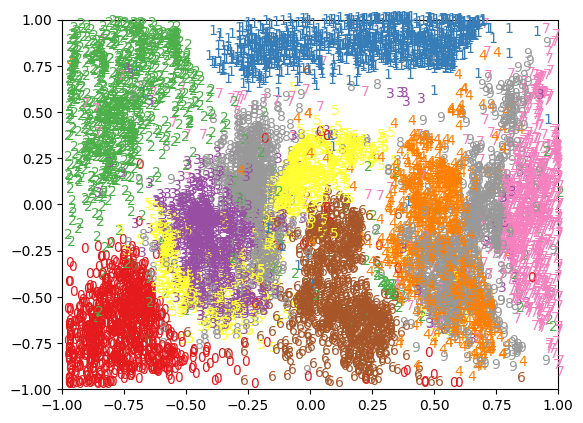

In [6]:
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, download=True, transform= transforms.ToTensor()),batch_size=20)# Test

axis_x = []
axis_y = []
answers = []
model_encoder.eval()
model_decoder.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        inputs = data.view(-1, 28*28).to(device)
        answers += target.tolist()
        # Forward
        model_encoder.zero_grad()
        model_decoder.zero_grad()
        
        codes = model_encoder(inputs)
        decoded = model_decoder(codes)
        codes = codes.detach().cpu()
        axis_x += codes[:, 0].tolist()
        axis_y += codes[:, 1].tolist()
answers = np.array(answers)
axis_x = np.array(axis_x)
axis_y = np.array(axis_y)
fig, ax = plt.subplots()
for i in range(len(answers)):
    ax.text(axis_x[i], axis_y[i], str(answers[i]), color=plt.cm.Set1(answers[i]))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

/tmp/ipykernel_29571/2334137335.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  codes = torch.FloatTensor(data)


Generated Images by AE


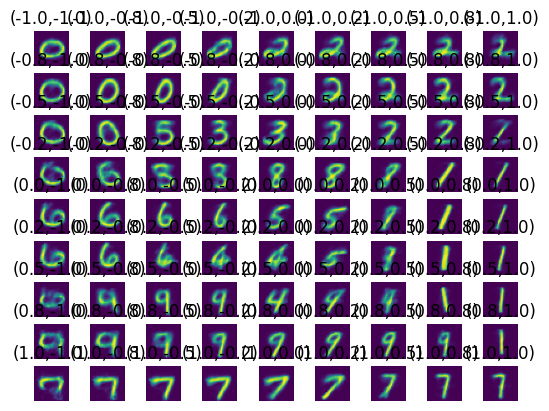

In [7]:
# Show images
def show_images(images, pos):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.title('({:.1f},{:.1f})'.format(pos[index,0],pos[index,1]))
        plt.axis('off')# Load model
data=[]
pos=[]
n_split=4
for i in range(2*n_split+1):
    for j in range(2*n_split+1):
        pos.append([(i-n_split)*(1/n_split), (j-n_split)*(1/n_split)])
        data.append(np.array([(i-n_split)*(1/n_split), (j-n_split)*(1/n_split)]))

pos = np.array(pos)
codes = torch.FloatTensor(data)
model_decoder = torch.load('mode_AutoEncoder_MNIST_Decoder.pth')
model_decoder.eval()
outputs = model_decoder(codes.to(device))
outputs = outputs.detach().cpu()
print('Generated Images by AE')
show_images(outputs, pos)
plt.show()

Generated Images by AE


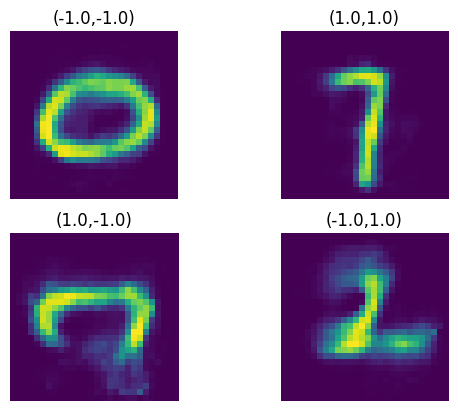

In [8]:
pos = np.array([[-1.0,-1.0],[1.0,1.0],[1,-1],[-1,1]])
codes = torch.FloatTensor([[-1.0,-1.0],[1.0,1.0],[1,-1],[-1,1]])
device=torch.device('cpu')
model_decoder = torch.load('mode_AutoEncoder_MNIST_Decoder.pth', map_location=torch.device('cpu'))
model_decoder.eval()
outputs = model_decoder(codes.to(device))
outputs = outputs.detach().cpu()
print('Generated Images by AE')
show_images(outputs, pos)
plt.show()